In [2]:
from pyspark.sql.types import * 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate();

spark = SparkSession(sc)

unsw_nb15 = StructType([
    StructField("srcip",StringType(),True),
    StructField("sport",IntegerType(),True),
    StructField("dstip",StringType(),True),
    StructField("dsport",IntegerType(),True),
    StructField("proto",StringType(),True),
    StructField("state",StringType(),True),
    StructField("dur",FloatType(),True),
    StructField("sbytes",IntegerType(),True),
    StructField("dbytes",IntegerType(),True),
    StructField("sttl",IntegerType(),True),
    StructField("dttl",IntegerType(),True),
    StructField("sloss",IntegerType(),True),
    StructField("dloss",IntegerType(),True),
    StructField("service",StringType(),True),
    StructField("Sload",FloatType(),True),
    StructField("Dload",FloatType(),True),
    StructField("Spkts",IntegerType(),True),
    StructField("Dpkts",IntegerType(),True),
    StructField("swin",IntegerType(),True),
    StructField("dwin",IntegerType(),True),
    StructField("stcpb",IntegerType(),True),
    StructField("dtcpb",IntegerType(),True),
    StructField("smeansz",IntegerType(),True),
    StructField("dmeansz",IntegerType(),True),
    StructField("trans_depth",IntegerType(),True),
    StructField("res_bdy_len",IntegerType(),True),
    StructField("Sjit",FloatType(),True),
    StructField("Djit",FloatType(),True),
    StructField("Stime",TimestampType(),True),
    StructField("Ltime",TimestampType(),True),
    StructField("Sintpkt",FloatType(),True),
    StructField("Dintpkt",FloatType(),True),
    StructField("tcprtt",FloatType(),True),
    StructField("synack",FloatType(),True),
    StructField("ackdat",FloatType(),True),
    StructField("is_sm_ips_ports",IntegerType(),True),
    StructField("ct_state_ttl",IntegerType(),True),
    StructField("ct_flw_http_mthd",IntegerType(),True),
    StructField("is_ftp_login",IntegerType(),True),
    StructField("ct_ftp_cmd",IntegerType(),True),
    StructField("ct_srv_src",IntegerType(),True),
    StructField("ct_srv_dst",IntegerType(),True),
    StructField("ct_dst_ltm",IntegerType(),True),
    StructField("ct_src_ltm",IntegerType(),True),
    StructField("ct_src_dport_ltm",IntegerType(),True),
    StructField("ct_dst_sport_ltm",IntegerType(),True),
    StructField("ct_dst_src_ltm",IntegerType(),True),
    StructField("attack_cat",StringType(),True),
    StructField("Label",IntegerType(),True)
])

unsw_nb15_df = spark.read.schema(unsw_nb15).format("csv").load("hdfs://localhost:9000/DataAnalysis/UNSW-NB15.csv").toDF("srcip","sport","dstip","dsport","proto","state","dur","sbytes","dbytes","sttl",
     "dttl","sloss","dloss","service","Sload","Dload","Spkts","Dpkts","swin","dwin",
     "stcpb","dtcpb","smeansz","dmeansz","trans_depth","res_bdy_len","Sjit","Djit",
     "Stime","Ltime","Sintpkt","Dintpkt","tcprtt","synack","ackdat","is_sm_ips_ports",
     "ct_state_ttl","ct_flw_http_mthd","is_ftp_login","ct_ftp_cmd","ct_srv_src",
     "ct_srv_dst","ct_dst_ltm","ct_src_ltm","ct_src_dport_ltm","ct_dst_sport_ltm",
     "ct_dst_src_ltm","attack_cat","Label")


24/05/05 03:17:32 WARN Utils: Your hostname, bunmialex-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.23.128 instead (on interface ens33)
24/05/05 03:17:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/05 03:17:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/05 03:17:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/05/05 03:17:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
from pyspark.sql.functions import col
from pyspark.sql.functions import when

In [4]:
default_string = "Normal"
filled_df = unsw_nb15_df.withColumn("attack_cat", when(unsw_nb15_df["attack_cat"].isNull(), default_string).otherwise(unsw_nb15_df["attack_cat"]))

In [5]:
columns_to_drop = ["srcip","dstip","stcpb", "dtcpb", "Stime","Ltime"]
cleaned_df = filled_df.drop(*columns_to_drop)

In [6]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder

SI_proto = StringIndexer(inputCol='proto',outputCol='proto_Index')
SI_state = StringIndexer(inputCol='state',outputCol='state_Index')
SI_service = StringIndexer(inputCol='service',outputCol='service_Index')
SI_attack_cat = StringIndexer(inputCol='attack_cat',outputCol='attack_cat_Index')

cleaned_df = SI_proto.fit(cleaned_df).transform(cleaned_df)
cleaned_df = SI_state.fit(cleaned_df).transform(cleaned_df)
cleaned_df = SI_service.fit(cleaned_df).transform(cleaned_df)
cleaned_df = SI_attack_cat.fit(cleaned_df).transform(cleaned_df)

In [7]:
OHE = OneHotEncoder(inputCols=['proto_Index','state_Index','service_Index','attack_cat_Index'],outputCols=['proto_OHE','state_OHE','service_OHE','attack_cat_OHE'])
cleaned_df = OHE.fit(cleaned_df).transform(cleaned_df)

In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['sport','dsport','dur','sbytes','dbytes','sttl','dttl','sloss','dloss','Sload','Dload','Spkts',
                                       'Dpkts','swin','dwin','smeansz','dmeansz','trans_depth','res_bdy_len','Sjit','Djit','Sintpkt',
                                       'Dintpkt','tcprtt','synack','ackdat','is_sm_ips_ports','ct_state_ttl','ct_flw_http_mthd','is_ftp_login',
                                       'Sintpkt','ct_ftp_cmd','ct_srv_src','ct_srv_dst','ct_dst_ltm','ct_src_ltm','ct_src_dport_ltm',
                                       'ct_dst_sport_ltm','ct_dst_src_ltm','proto_Index','ct_dst_src_ltm','state_Index',
                                       'service_Index','attack_cat_Index','proto_OHE','state_OHE','service_OHE','attack_cat_OHE'],
                           outputCol='features')

In [18]:
cleaned_df = cleaned_df.fillna(0)

final_data = assembler.transform(cleaned_df)

In [19]:
model_df = final_data.select(['features','Label'])
model_df = model_df.withColumnRenamed("Label",'label_class')
model_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label_class: integer (nullable = true)



In [20]:
training_df,test_df = model_df.randomSplit([0.8,0.2],seed=123)

In [21]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label_class", featuresCol="features")
model = lr.fit(training_df)

24/05/05 03:28:19 WARN MemoryStore: Not enough space to cache rdd_127_2 in memory! (computed 65.0 MiB so far)
24/05/05 03:28:19 WARN BlockManager: Persisting block rdd_127_2 to disk instead.
24/05/05 03:28:20 WARN MemoryStore: Not enough space to cache rdd_127_0 in memory! (computed 65.0 MiB so far)
24/05/05 03:28:20 WARN BlockManager: Persisting block rdd_127_0 to disk instead.
24/05/05 03:28:21 WARN MemoryStore: Not enough space to cache rdd_127_1 in memory! (computed 65.0 MiB so far)
24/05/05 03:28:21 WARN BlockManager: Persisting block rdd_127_1 to disk instead.
24/05/05 03:28:24 WARN MemoryStore: Not enough space to cache rdd_127_3 in memory! (computed 177.1 MiB so far)
24/05/05 03:28:24 WARN BlockManager: Persisting block rdd_127_3 to disk instead.
24/05/05 03:28:27 WARN MemoryStore: Not enough space to cache rdd_127_2 in memory! (computed 113.0 MiB so far)
24/05/05 03:28:28 WARN MemoryStore: Not enough space to cache rdd_127_0 in memory! (computed 113.0 MiB so far)
24/05/05 03:2

In [22]:
predictions = model.transform(test_df)

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label_class")
area_under_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})

In [24]:
print("Area under ROC:", area_under_roc)

Area under ROC: 0.9999994639602303


In [25]:
predictions.select('label_class','prediction').show(50)

+-----------+----------+
|label_class|prediction|
+-----------+----------+
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|


In [26]:
model_summary = model.summary

In [27]:
model_summary.accuracy

1.0

24/05/05 13:12:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 228642 ms exceeds timeout 120000 ms
24/05/05 13:12:33 WARN SparkContext: Killing executors is not supported by current scheduler.


In [51]:
print(model_summary.precisionByLabel)

[1.0, 1.0]


In [52]:
print(model_summary.recallByLabel)

[1.0, 1.0]


In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve


In [54]:
pred_labels = predictions.select(['prediction', 'label_class']).rdd.map(lambda row: (float(row['prediction']), float(row['label_class'])))


In [55]:
preds = pred_labels.map(lambda x: x[0]).collect()
labels = pred_labels.map(lambda x: x[1]).collect()

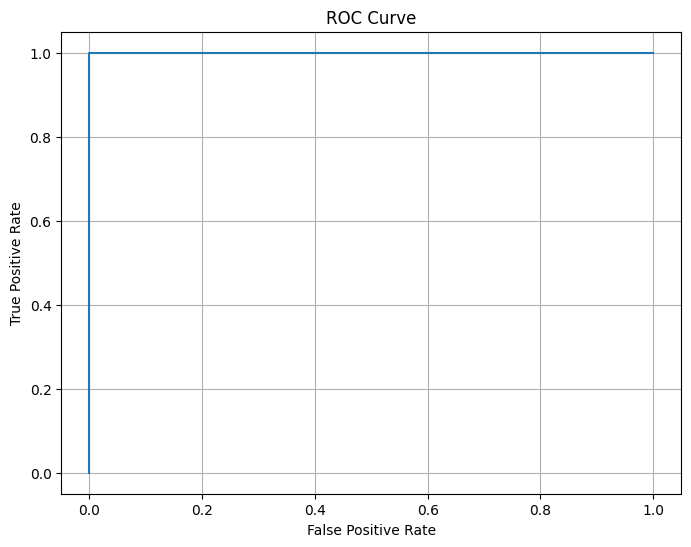

In [56]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(labels, preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

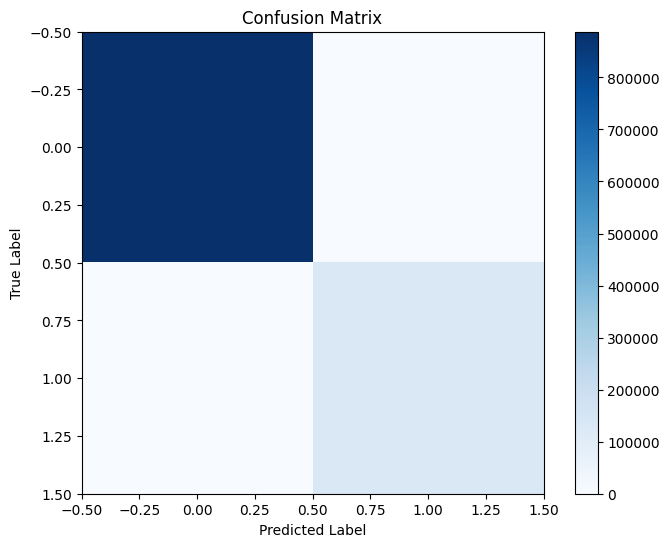

In [57]:
# Confusion Matrix
cm = confusion_matrix(labels, np.round(preds))
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

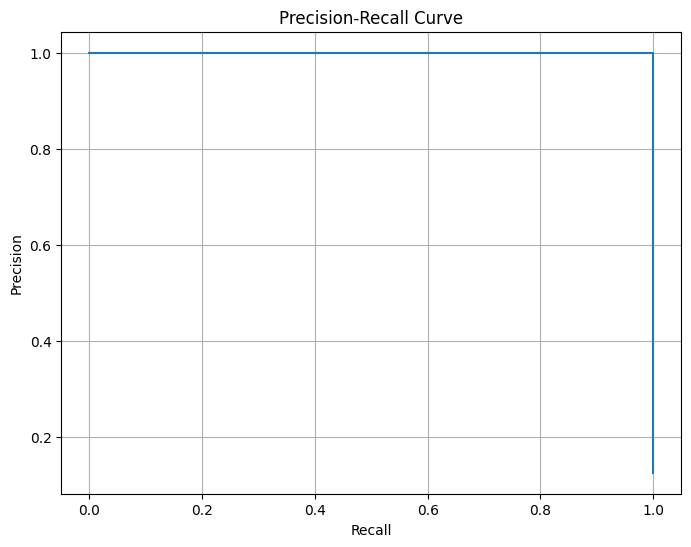

In [58]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(labels, preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()